# First Experiment

*CHECK THIS SETUP RESOURCES*

Driver:

    - cores: 1
    - coreLimit: "1200m"
    - memory: "6g"

Executor:

    - cores: 2
    - instances: 4
    - memory: "8g"

`"max.in.flight.requests.per.connection": 1`

In [102]:
import pandas as pd
from pandas.tseries.frequencies import to_offset

df_cloud = pd.read_parquet("../data/raw/first_experiment/2025-04-21-19_17_24-avro-cloud.parquet")
df_cloud = df_cloud.sort_values("source_timestamp")
df_edge = pd.read_parquet("../data/raw/first_experiment/2025-04-21-19_00_31-avro-edge.parquet")
df_edge = df_edge.sort_values("source_timestamp")

In [103]:
def fix_timestamps_timezone(df: pd.DataFrame) -> pd.DataFrame:
    # Corrigindo 'source_timestamp' que está como São Paulo mas deveria ser UTC
    df["source_timestamp"] = (
        df["source_timestamp"]
        .dt.tz_convert(None)         # Remove o timezone mantendo o horário
        .dt.tz_localize("UTC")       # Aplica UTC como se o horário fosse UTC mesmo
    )
    # Adiciona 3 horas e seta fuso como UTC
    df["source_timestamp"] = (
        df["source_timestamp"]
        - pd.Timedelta(hours=3)
    )
    df["timestamp"] = df["timestamp"].dt.tz_convert("UTC")
    df["landing_timestamp"] = df["landing_timestamp"].dt.tz_convert("UTC")

    return df

In [104]:
df_cloud = fix_timestamps_timezone(df_cloud)
df_edge = fix_timestamps_timezone(df_edge)

In [106]:
def calculate_latencies(df: pd.DataFrame) -> pd.DataFrame:
    df["source_kafka_latency"] = (df["timestamp"] - df["source_timestamp"]).dt.total_seconds()
    df["kafka_landing_latency"] = (df["landing_timestamp"] - df["timestamp"]).dt.total_seconds()

    return df

In [107]:
df_cloud = calculate_latencies(df_cloud)
df_edge = calculate_latencies(df_edge)

There was a broker replica failure on edge just before 17h20. So a filter was applied after this time to observe normal processing conditions.

In [108]:
# 1. Encontrar o intervalo comum entre os dois dataframes
# start_time = max(df_cloud["source_timestamp"].min(), df_edge["source_timestamp"].min())
start_time = pd.Timestamp("2025-04-21 17:20:00", tz="UTC")
end_time = min(df_cloud["source_timestamp"].max(), df_edge["source_timestamp"].max())

# 2. Filtrar ambos os dataframes para esse intervalo
df_cloud_filtered = df_cloud[
    (df_cloud["source_timestamp"] >= start_time) &
    (df_cloud["source_timestamp"] <= end_time)
]

df_edge_filtered = df_edge[
    (df_edge["source_timestamp"] >= start_time) &
    (df_edge["source_timestamp"] <= end_time)
]

/tmp/ipykernel_12489/2896899169.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxplot, x="Environment", y="source_kafka_latency", palette=custom_palette)


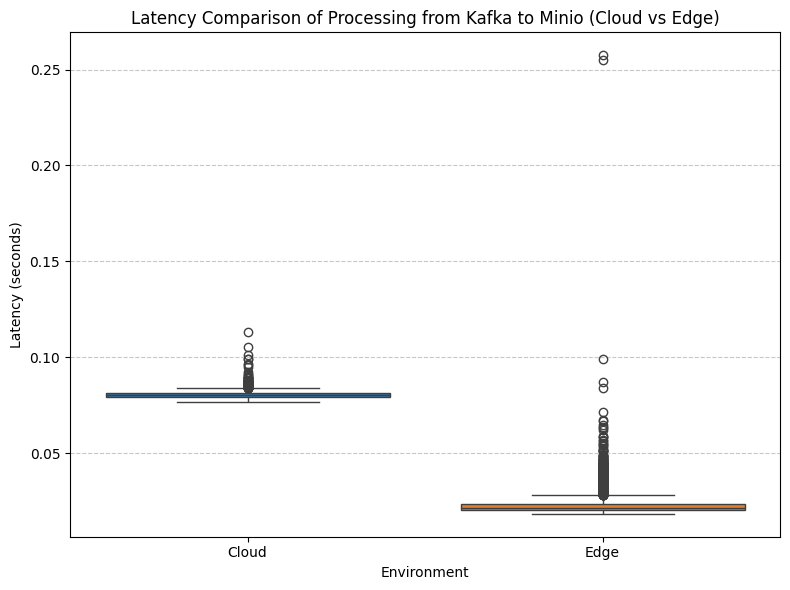

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom colors for each category
custom_palette = {
    "Cloud": "#1f77b4",  # blue
    "Edge": "#ff7f0e"    # orange
}

# 1. Criar cópias dos dataframes com coluna de origem
df_cloud_box = df_cloud_filtered[["source_kafka_latency"]].copy()
df_cloud_box["Environment"] = "Cloud"

df_edge_box = df_edge_filtered[["source_kafka_latency"]].copy()
df_edge_box["Environment"] = "Edge"

# 2. Concatenar os dois
df_boxplot = pd.concat([df_cloud_box, df_edge_box], ignore_index=True)

# 3. Plotar com Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_boxplot, x="Environment", y="source_kafka_latency", palette=custom_palette)
plt.title("Latency Comparison of Processing from Kafka to Minio (Cloud vs Edge)")
plt.ylabel("Latency (seconds)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observing the image, the average latency to the Edge is lower than to the Cloud, as expected, since the Cloud server is located in New York, while the Edge server is in the same city (Florianópolis) as the PC that was publishing data to Kafka.

However, it is possible to observe that the Edge setup had more outliers, with latencies reaching up to 250 ms.

A new test should be considered in a setup closer to the server (e.g., within the same building), avoiding the use of a VPN and attempting to connect via NodePort instead of Ingress. This is because the Cloud environment runs under these conditions (No VPN and over NodePort with no Ingress), and some instabilities were observed in the Edge MinIO connection, which could be related to the Ingress configuration.

Additionally, for the Cloud environment, using a server located in Brazil could potentially reduce latency.

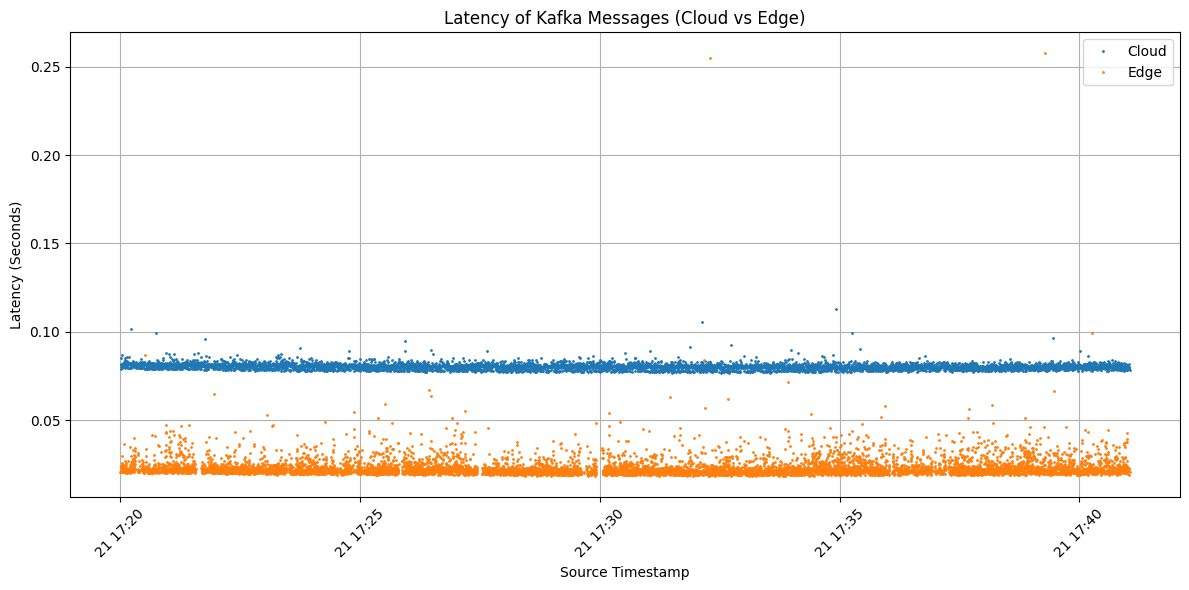

In [110]:
import matplotlib.pyplot as plt

# Plotar
plt.figure(figsize=(12, 6))
plt.plot(df_cloud_filtered['source_timestamp'], df_cloud_filtered['source_kafka_latency'], label='Cloud', marker='o', linestyle='none', markersize=1)
plt.plot(df_edge_filtered['source_timestamp'], df_edge_filtered['source_kafka_latency'], label='Edge', marker='o', linestyle='none', markersize=1)
plt.xlabel('Source Timestamp')
plt.ylabel('Latency (Seconds)')
plt.title('Latency of Kafka Messages (Cloud vs Edge)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observing this plot, it is also possible to notice that the Cloud environment shows less deviation from the average.

Additionally, there are moments in the Edge plot with noticeable gaps, which may indicate connection instabilities.

📊 Statistics:
                 mean    median       std
Environment                              
Cloud        0.080314  0.080252  0.001844
Edge         0.022977  0.021517  0.005925


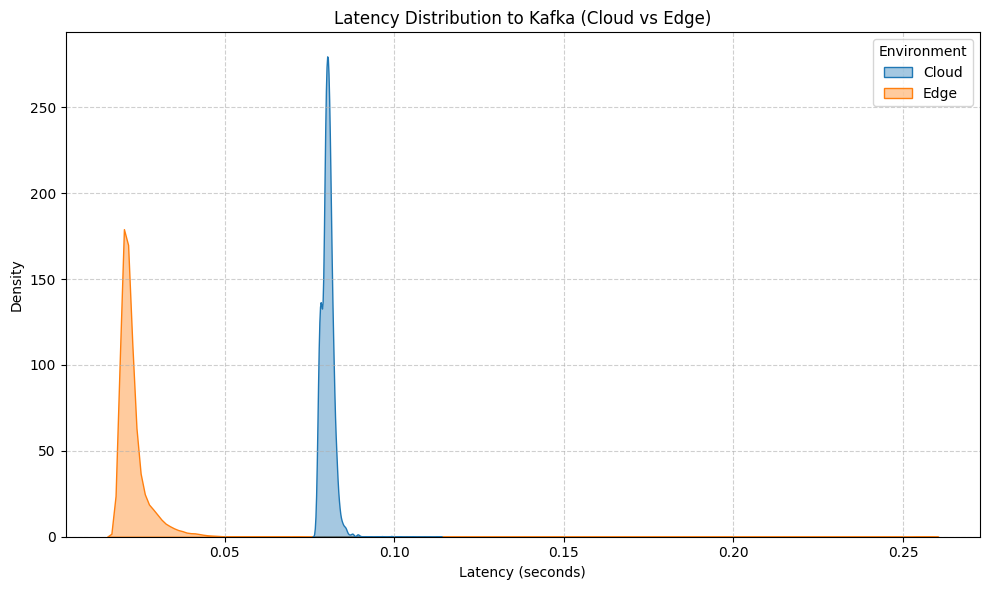

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Unir os dados com coluna de origem
df_cloud_kde = df_cloud_filtered[["source_kafka_latency"]].copy()
df_cloud_kde["Environment"] = "Cloud"

df_edge_kde = df_edge_filtered[["source_kafka_latency"]].copy()
df_edge_kde["Environment"] = "Edge"

df_kde = pd.concat([df_cloud_kde, df_edge_kde], ignore_index=True)

# 2. Calcular estatísticas
stats = df_kde.groupby("Environment")["source_kafka_latency"].agg(["mean", "median", "std"])
print("📊 Statistics:")
print(stats)

# 3. Plotar a curva de distribuição
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_kde, x="source_kafka_latency", hue="Environment", fill=True, common_norm=False, alpha=0.4)

plt.title("Latency Distribution to Kafka (Cloud vs Edge)")
plt.xlabel("Latency (seconds)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_12489/2530671441.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxplot, x="Environment", y="kafka_landing_latency", palette=custom_palette)


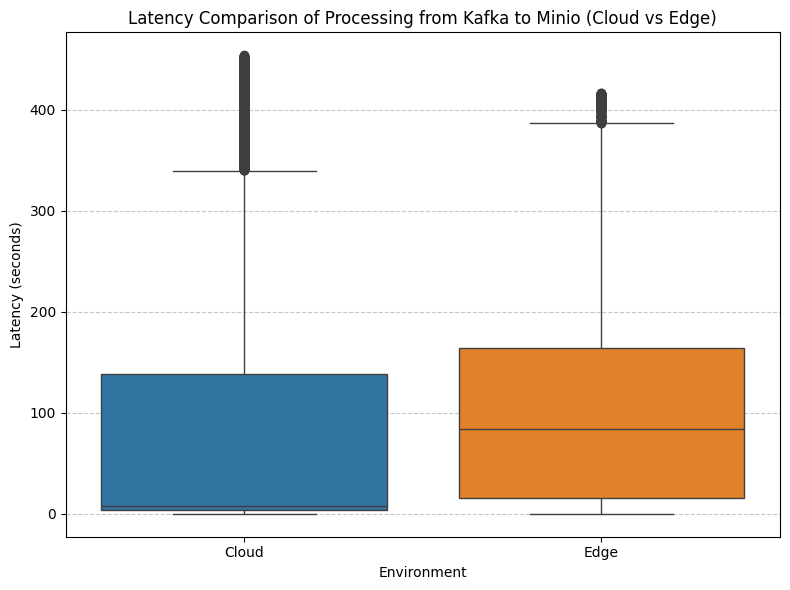

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom colors for each category
custom_palette = {
    "Cloud": "#1f77b4",  # blue
    "Edge": "#ff7f0e"    # orange
}

# 1. Criar cópias dos dataframes com coluna de origem
df_cloud_box = df_cloud_filtered[["kafka_landing_latency"]].copy()
df_cloud_box["Environment"] = "Cloud"

df_edge_box = df_edge_filtered[["kafka_landing_latency"]].copy()
df_edge_box["Environment"] = "Edge"

# 2. Concatenar os dois
df_boxplot = pd.concat([df_cloud_box, df_edge_box], ignore_index=True)

# 3. Plotar com Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_boxplot, x="Environment", y="kafka_landing_latency", palette=custom_palette)
plt.title("Latency Comparison of Processing from Kafka to Minio (Cloud vs Edge)")
plt.ylabel("Latency (seconds)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

For the data lake processing cloud performed better in average, but edge seems to have less standard deviation. 

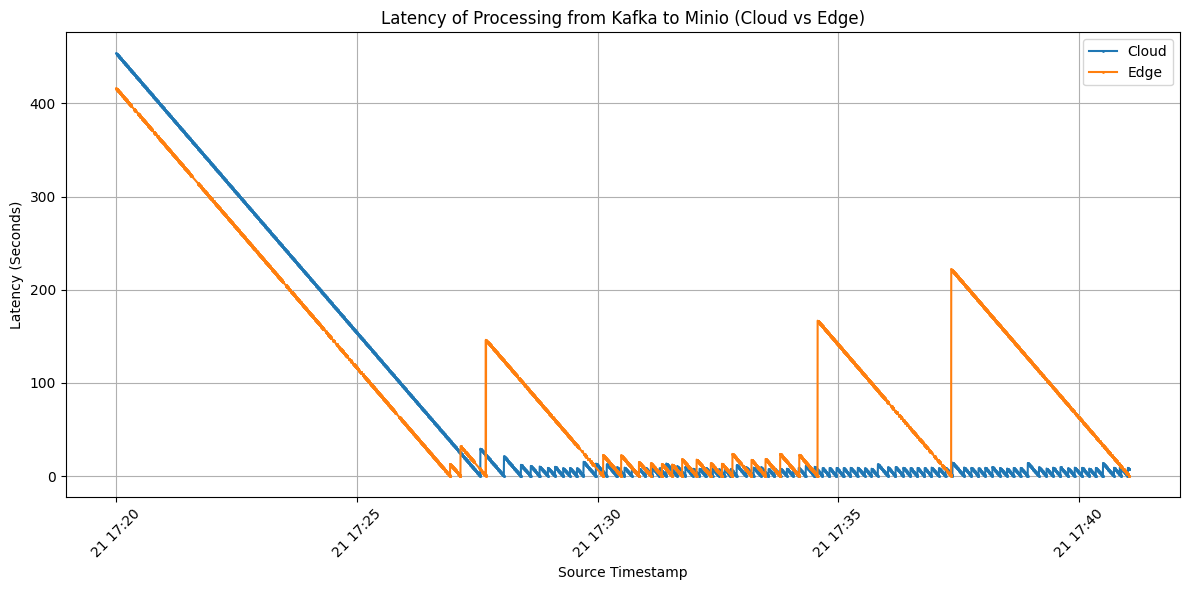

In [113]:
import matplotlib.pyplot as plt

# Plotar
plt.figure(figsize=(12, 6))
plt.plot(df_cloud_filtered['source_timestamp'], df_cloud_filtered['kafka_landing_latency'], label='Cloud', marker='o', markersize=1)
plt.plot(df_edge_filtered['source_timestamp'], df_edge_filtered['kafka_landing_latency'], label='Edge', marker='o', markersize=1)
plt.xlabel('Source Timestamp')
plt.ylabel('Latency (Seconds)')
plt.title('Latency of Processing from Kafka to Minio (Cloud vs Edge)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The first slope in both cases represents the initial load of accumulated data in the Kafka topic.

The subsequent slopes correspond to Spark Structured Streaming micro-batches. Although the stream is configured to process data every second, it cannot consistently meet this interval, resulting in data accumulation.

It is interesting to note that, in the Edge setup, there was a greater accumulation of data, as indicated by the higher peaks in the "sawtooth" pattern.

📊 Statistics:
                   mean   median         std
Environment                                 
Cloud         84.980715   7.5480  132.223557
Edge         109.477208  83.4215  106.909022


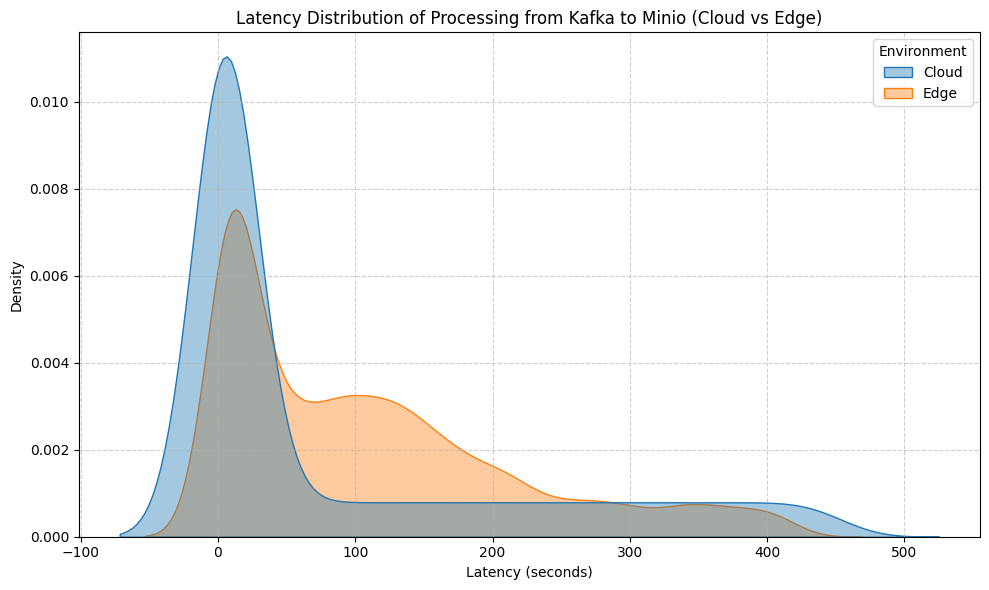

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Unir os dados com coluna de origem
df_cloud_kde = df_cloud_filtered[["kafka_landing_latency"]].copy()
df_cloud_kde["Environment"] = "Cloud"

df_edge_kde = df_edge_filtered[["kafka_landing_latency"]].copy()
df_edge_kde["Environment"] = "Edge"

df_kde = pd.concat([df_cloud_kde, df_edge_kde], ignore_index=True)

# 2. Calcular estatísticas
stats = df_kde.groupby("Environment")["kafka_landing_latency"].agg(["mean", "median", "std"])
print("📊 Statistics:")
print(stats)

# 3. Plotar a curva de distribuição
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_kde, x="kafka_landing_latency", hue="Environment", fill=True, common_norm=False, alpha=0.4)

plt.title("Latency Distribution of Processing from Kafka to Minio (Cloud vs Edge)")
plt.xlabel("Latency (seconds)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
